# ENEL 645 - W2023
## Assignment 2 - Tutorial Creation  
Group 4:  
Ayodele Oyelese  
Stewart Pratt  
Shawn Lee  
Nicolas Hirschfeld  
Nicholas Lor  
Tania So

# Introduction


For our tutorial we chose to use a transfer learning model to determine the different breeds of dogs. We utilized PyTorch's Resnet50 model as our pretrained model as it is a quick model and has a good supply of dog features pre-trained. Our dataset is sourced from this Kaggle data set https://www.kaggle.com/datasets/gpiosenka/70-dog-breedsimage-data-set.

#Step 0: Required Imports

In [1]:
import zipfile
import os

import torchvision.models as models
import torchvision.transforms as transforms
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import utils
from torchvision import datasets
from torch.utils.data import Dataset

import cv2                
import matplotlib.pyplot as plt 

import numpy as np   
from PIL import Image
from PIL import ImageFile

#Step 1: Import Dataset

The data sets are saved directly on our gitHub Repository. 


#OPTION 1:
 USING WGET. This module was run using wget to import the zip file containing the Dataset from our github repo.

In [2]:
import zipfile
import os

!wget  --no-check-certificate \
"https://github.com/segpratt/ENEL-645-Assignment2-Dog-Classifier/archive/refs/heads/main.zip" \
    -O "/tmp/Assignment2TrainDataSet.zip"

zip_ref = zipfile.ZipFile('/tmp/Assignment2TrainDataSet.zip', 'r') #Opens the zip file in read mode
zip_ref.extractall('/tmp') #Extracts the files into the /tmp folder
zip_ref.close()

--2023-03-07 01:20:42--  https://github.com/segpratt/ENEL-645-Assignment2-Dog-Classifier/archive/refs/heads/main.zip
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/segpratt/ENEL-645-Assignment2-Dog-Classifier/zip/refs/heads/main [following]
--2023-03-07 01:20:42--  https://codeload.github.com/segpratt/ENEL-645-Assignment2-Dog-Classifier/zip/refs/heads/main
Resolving codeload.github.com (codeload.github.com)... 140.82.114.10
Connecting to codeload.github.com (codeload.github.com)|140.82.114.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘/tmp/Assignment2TrainDataSet.zip’

/tmp/Assignment2Tra     [   <=>              ] 215.79M  29.2MB/s    in 7.4s    

2023-03-07 01:20:50 (29.2 MB/s) - ‘/tmp/Assignment2TrainDataSet.zip’ saved [226268226]



#OPTION 2:
Using requests, zipfile, io libraries to import from github. Please uncomment and run next cell if you want to use option 2 to import dataset.

In [20]:
#import requests, zipfile, io
#r = requests.get("https://github.com/hirschfeldnic/ENEL-645-Assignment2-Dog-Classifier/archive/refs/heads/main.zip")
#z = zipfile.ZipFile(io.BytesIO(r.content))
#z.extractall("/tmp")

In [3]:
#Obtain paths where files are stored for training, validation and testing
train_dataset_path = '/tmp/ENEL-645-Assignment2-Dog-Classifier-main/dataset/train/'
val_dataset_path = '/tmp/ENEL-645-Assignment2-Dog-Classifier-main/dataset/valid/'
test_dataset_path = '/tmp/ENEL-645-Assignment2-Dog-Classifier-main/dataset/test/'




#Step 2: Data Pre-processing

In [4]:
ImageFile.LOAD_TRUNCATED_IMAGES = True
# Specify Transforms for data augementation as well as Normalization and STD
# Used mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225] which specified in the pytorch Documentation for models using imagenet aka the Resnet model
# Convert to Tensor
# Used random flips as well as random cropping to data augment
torchvision_transform = transforms.Compose([transforms.Resize(256),
                                  transforms.RandomResizedCrop(224),
                                  transforms.RandomHorizontalFlip(),
                                  transforms.RandomRotation(10),
                                  transforms.ToTensor(),
                                  transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                       std=[0.229, 0.224, 0.225])])


torchvision_transform_test = transforms.Compose([transforms.Resize(256),
                                  transforms.CenterCrop(224),
                                  transforms.ToTensor(),
                                  transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                       std=[0.229, 0.224, 0.225])])

In [5]:
# load datasets and apply transformations
train_dataset = datasets.ImageFolder(train_dataset_path, transform=torchvision_transform)
val_dataset = datasets.ImageFolder(val_dataset_path, transform=torchvision_transform)
test_dataset = datasets.ImageFolder(test_dataset_path, transform=torchvision_transform_test)


In [6]:
# Specify Workers and batch size
workers = 0
b_size = 20

In [7]:
# Create the data loaders
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size= b_size, shuffle = True, num_workers= workers)
valloader = torch.utils.data.DataLoader(val_dataset, batch_size= b_size, num_workers= workers)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size= b_size, num_workers= workers)

# Step 3: Check the Data is Loaded Correctly

In [8]:
# Get the all dog breed labels
breed_names = train_dataset.classes
print(breed_names)

['Afghan', 'African Wild Dog', 'Airedale', 'American Hairless', 'American Spaniel', 'Basenji', 'Basset', 'Beagle', 'Bearded Collie', 'Bermaise', 'Bichon Frise', 'Blenheim', 'Bloodhound', 'Bluetick', 'Border Collie', 'Borzoi', 'Boston Terrier', 'Boxer', 'Bull Mastiff', 'Bull Terrier', 'Bulldog', 'Cairn', 'Chihuahua', 'Chinese Crested', 'Chow', 'Clumber', 'Cockapoo', 'Cocker', 'Collie', 'Corgi', 'Coyote', 'Dalmation', 'Dhole', 'Dingo', 'Doberman', 'Elk Hound', 'French Bulldog', 'German Sheperd', 'Golden Retriever', 'Great Dane', 'Great Perenees', 'Greyhound', 'Groenendael', 'Irish Spaniel', 'Irish Wolfhound', 'Japanese Spaniel', 'Komondor', 'Labradoodle', 'Labrador', 'Lhasa', 'Malinois', 'Maltese', 'Mex Hairless', 'Newfoundland', 'Pekinese', 'Pit Bull', 'Pomeranian', 'Poodle', 'Pug', 'Rhodesian', 'Rottweiler', 'Saint Bernard', 'Schnauzer', 'Scotch Terrier', 'Shar_Pei', 'Shiba Inu', 'Shih-Tzu', 'Siberian Husky', 'Vizsla', 'Yorkie']


In [9]:
# Check the size of the dataSet
num_breeds = len(train_dataset.classes)

print('Training Size: {}'.format(len(train_dataset)))
print('Validation Size: {}'.format(len(val_dataset)))
print('Test Size: {}'.format(len(test_dataset)))
print('Number of breeds: {}'.format(num_breeds))


Training Size: 7946
Validation Size: 700
Test Size: 700
Number of breeds: 70


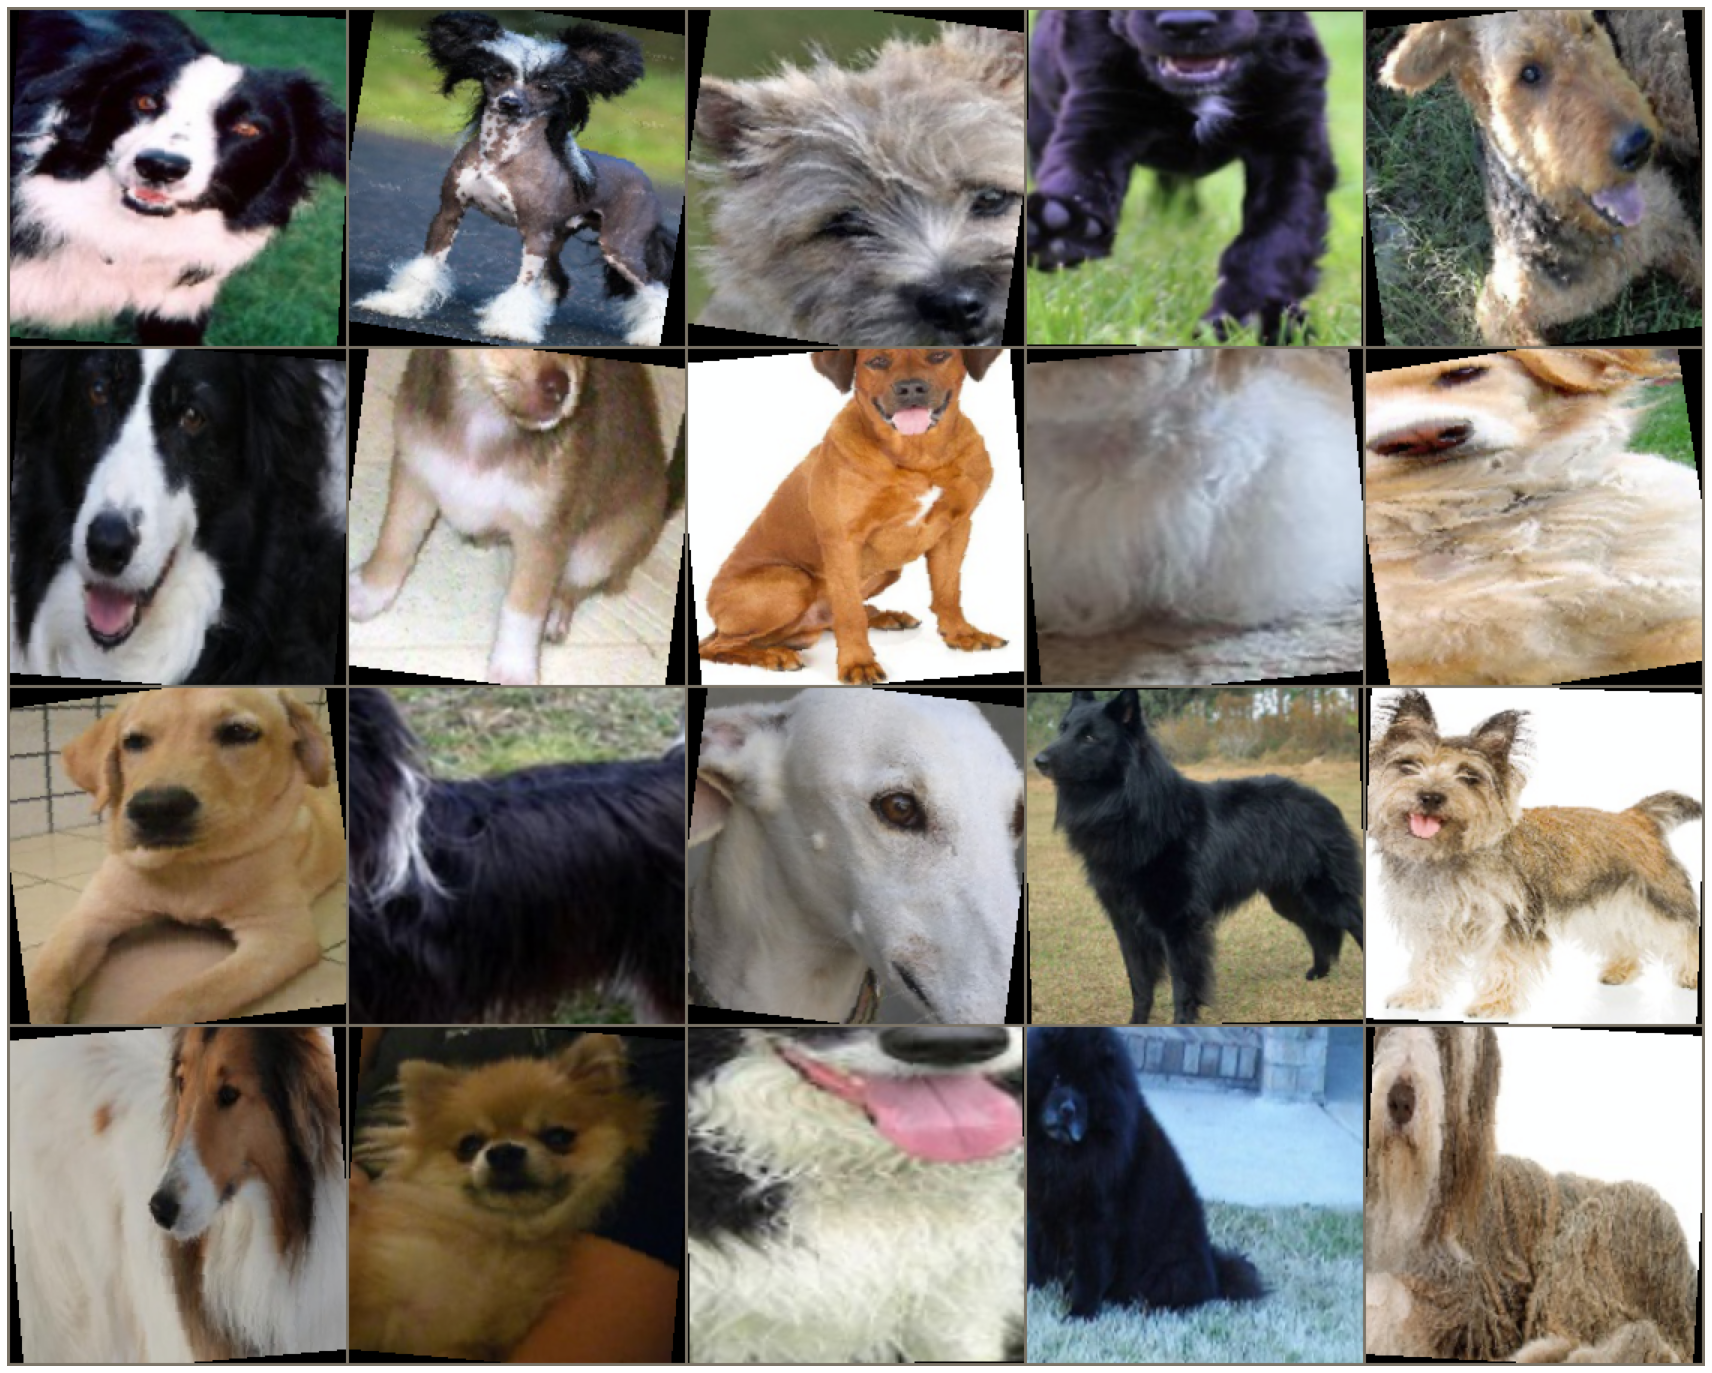

In [10]:
                
%matplotlib inline                               

# Get some images to check the data set looks alright
def show_images(inp):
    inp = inp.numpy().transpose((1, 2, 0))
    inp = inp * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    inp = np.clip(inp, 0, 1)
    
    fig = plt.figure(figsize=(60, 25))
    plt.axis('off')
    plt.imshow(inp)
    plt.pause(0.001)
      
inputs, classes = next(iter(trainloader))

#Format style
grid = utils.make_grid(inputs, nrow=5)
show_images(grid)

#Step 4: Obtain Pre-Trained Resnet50 Model

In [11]:
# Specify model architecture 
model = models.resnet50(pretrained=True)

# Freeze parameters in pre-trained model
for param in model.parameters():
    param.requires_grad = False

# Replace the last fully connected layer with a Linear layer 
# Linear layer has 70 out features
model.fc = nn.Linear(2048, 70)

# is CUDA available?
use_cuda = torch.cuda.is_available()

if use_cuda:
    model = model.cuda()


/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

#Step 5: Define Callbacks

In [12]:
def train(n_epochs, train_loader, val_loader, model, optimizer, criterion, use_cuda, save_path, patience=5):
    """returns trained model"""
    # initialize tracker to find minimum validation loss
    validation_loss_minimum = np.Inf 
    # initialize counter for number of epochs with no improvement in validation loss
    patience_counter = 0
    # set the initial best validation loss to infinity
    best_validation_loss = np.Inf
    
    for epoch in range(1, n_epochs+1):
        # Initialize training and validation loss
        training_loss = 0.0
        validation_loss = 0.0
        
        # Train the model
        model.train()
        for batch_idx, (data, target) in enumerate(train_loader):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            # capture the loss and update the model parameters accordingly
            # record and update the average training_loss

            # clear the gradients (grad) of optimized variables
            # initialize weights to be zero
            optimizer.zero_grad()
            # forward pass
            output = model(data)
            # calculate loss (batch loss)
            loss = criterion(output, target)
            # backward pass
            loss.backward()
            # parameter update
            optimizer.step()
            # update training_loss
            training_loss += loss.item() * data.size(0)
            
        # Validate the model
        model.eval()
        for batch_idx, (data, target) in enumerate(val_loader):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            # record and update the average validation_loss
            # forward pass
            output = model(data)
            # loss (batch loss)
            loss = criterion(output, target)
            # update validation_loss
            validation_loss += loss.item() * data.size(0)
            
        # calculate average training_loss
        training_loss = training_loss/len(train_loader.dataset)
        # calculate average validation_loss
        validation_loss = validation_loss/len(val_loader.dataset)
            
        # print statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            training_loss,
            validation_loss
            ))
        
        # check if validation loss has improved
        if validation_loss < best_validation_loss:
            print('Validation loss improved ({:.6f} --> {:.6f}).    Saving model...'.
                 format(best_validation_loss, validation_loss))
            torch.save(model.state_dict(), save_path)
            best_validation_loss = validation_loss
            patience_counter = 0
        else:
            patience_counter += 1
            print(f'Validation loss did not improve from {best_validation_loss:.6f}. Patience: {patience_counter}/{patience}')
            
            # check if we have reached the maximum patience
            if patience_counter >= patience:
                print(f'Early stopping at epoch {epoch}. Best Validation loss: {best_validation_loss:.6f}')
                return model
        
    # return trained model
    return model


In [13]:
# Determine loss parameters and learning rate
criterion_transfer = nn.CrossEntropyLoss()
optimizer_transfer = optim.Adam(model.fc.parameters(), lr=0.001)

# Step 6: Train the Model

In [14]:
# train the model
model =  train(10, trainloader, valloader, model, optimizer_transfer, criterion_transfer, use_cuda, 'model.pt')

Epoch: 1 	Training Loss: 2.180078 	Validation Loss: 1.241121
Validation loss improved (inf --> 1.241121).    Saving model...
Epoch: 2 	Training Loss: 1.336653 	Validation Loss: 1.254473
Validation loss did not improve from 1.241121. Patience: 1/5
Epoch: 3 	Training Loss: 1.249763 	Validation Loss: 1.190188
Validation loss improved (1.241121 --> 1.190188).    Saving model...
Epoch: 4 	Training Loss: 1.164151 	Validation Loss: 1.384277
Validation loss did not improve from 1.190188. Patience: 1/5
Epoch: 5 	Training Loss: 1.129016 	Validation Loss: 1.182497
Validation loss improved (1.190188 --> 1.182497).    Saving model...
Epoch: 6 	Training Loss: 1.139482 	Validation Loss: 1.193755
Validation loss did not improve from 1.182497. Patience: 1/5
Epoch: 7 	Training Loss: 1.128267 	Validation Loss: 1.118265
Validation loss improved (1.182497 --> 1.118265).    Saving model...
Epoch: 8 	Training Loss: 1.092357 	Validation Loss: 1.325062
Validation loss did not improve from 1.118265. Patience: 1

In [15]:
# take the best model from the training (Best validation loss)
model.load_state_dict(torch.load('model.pt'))

<All keys matched successfully>

#Step 7: Test the Model

In [16]:
def test(test_loader, model, criterion, use_cuda):

    # Initalize variables to determine accuracy
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(test_loader):
        # Use the GPUs
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        output = model(data)

        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

In [17]:
test(testloader, model, criterion_transfer, use_cuda)


Test Accuracy: 94% (662/700)


# Step 8: Test on Own Examples and Display
Images can be found in our repo in the folder test_Images/dogs

In [18]:
# CPU or GPU
device = torch.device("cuda:0" if use_cuda else "cpu")

# Load the trained model 'model.pt'
model.load_state_dict(torch.load('model.pt', map_location='cpu'))

<All keys matched successfully>

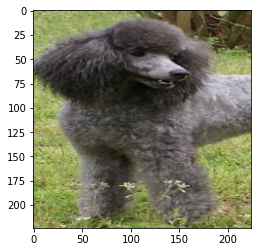

Actual Breed: Poodle, 	 prediction breed: Poodle


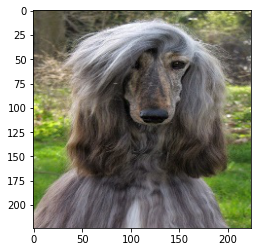

Actual Breed: Afghan, 	 prediction breed: Afghan


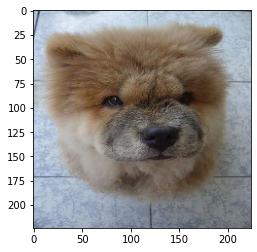

Actual Breed: Chow, 	 prediction breed: Chow


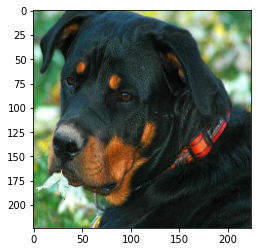

Actual Breed: Rottweiler, 	 prediction breed: Rottweiler


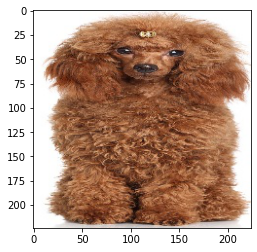

Actual Breed: Poodle_02, 	 prediction breed: Cockapoo


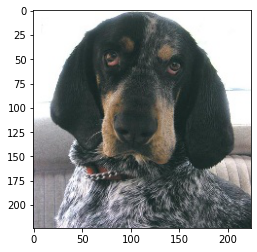

Actual Breed: Bluetick, 	 prediction breed: Bluetick


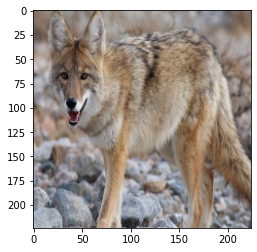

Actual Breed: Coyote, 	 prediction breed: Coyote


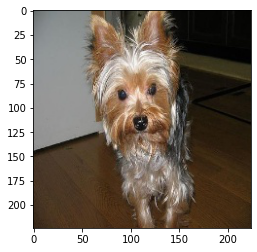

Actual Breed: Yorkie, 	 prediction breed: Yorkie


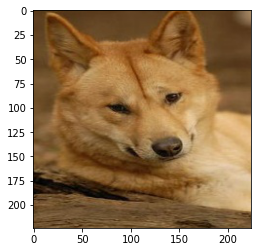

Actual Breed: Dingo, 	 prediction breed: Dingo


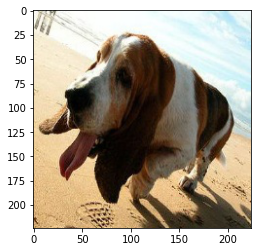

Actual Breed: Basset, 	 prediction breed: Basset


In [19]:

class_names = [item[:] for item in trainloader.dataset.classes]

def load_input_image(img_path):  
    #Opens the image using the PIL Image module and convert it to RGB mode  
    image = Image.open(img_path).convert('RGB')
    #Defines a series of image transformations using the torchvision.transforms.Compose() method
    prediction_transform = transforms.Compose([transforms.Resize(size=(224, 224)),
                                               transforms.ToTensor(), 
                                               transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                                    std=[0.229, 0.224, 0.225])])
    #Applies the defined transformations to the input image
    image = prediction_transform(image)[:3,:,:].unsqueeze(0)
    #Returns the transformed image as a tensor
    return image

#Defines a function to predict the breed of a dog
def predict_breed_transfer(model, class_names, img_path):
    # load the image and return the predicted breed
    img = load_input_image(img_path)
    img_show = Image.open(img_path)
    plt.imshow(img_show)
    plt.show()
    #Move the model to the CPU and set it to evaluation mode
    model = model.cpu()
    model.eval()
    idx = torch.argmax(model(img))
    return class_names[idx]

#Loop through each of the images in the test images folder and run the prediction on them
for img_file in os.listdir('/tmp/ENEL-645-Assignment2-Dog-Classifier-main/test_Images/dogs'):
    img_path = os.path.join('/tmp/ENEL-645-Assignment2-Dog-Classifier-main/test_Images/dogs', img_file)
    prediction = predict_breed_transfer(model, class_names, img_path)
    breed_name = img_path.split('/')[-1].split('.')[0]
    print("Actual Breed: {0}, \t prediction breed: {1}".format(breed_name, prediction))

